# Modeling

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Basics
import pandas as pd
import numpy as np
from datetime import datetime

#Viz
import matplotlib.pyplot as plt
import seaborn as sns

#Modeling utils
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve

#Estimators
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb

# Load in the data 

In [2]:
union_tod = pd.read_csv('union_df_tod.csv')

In [3]:
union_df = pd.read_csv('union_df.csv')

# Feature engineering

## Time variables

Now that we have our time variables as we wanted and the trip counts for each one of those points, we need to make sure that our cyclical variables, namely dayofyear, weekday and hour, preserve their cyclical characteristics of months, days and weeks. This is to say that, the first day of the week should be close to the last day of the previous week, and similar with hours and days of the year. A more in depth explanation of this can be found [here](http://blog.davidkaleko.com/feature-engineering-cyclical-features.html).

The transformation of monotonic variables into cyclical variables is explained in the following picture:

![alt text](http://blog.davidkaleko.com/images/unit_circle.png)

In this way, the hour 0 of a day will be preceded by the hour 23 of the previous day, and so on. For this, we use polar coordinates or sine and cosine components of these variables as follows.

In [4]:
# Transform three time variables sine and cosine components
union_tod['dayofyear_sin'] = np.sin(union_tod.dayofyear*(2.*np.pi/365))
union_tod['dayofyear_cos'] = np.cos(union_tod.dayofyear*(2.*np.pi/365))
union_tod['weekday_sin'] = np.sin(union_tod.weekday*(2.*np.pi/7))
union_tod['weekday_cos'] = np.cos(union_tod.weekday*(2.*np.pi/7))
union_tod['tod_sin'] = np.sin(union_tod.time_of_day*(2.*np.pi/24))
union_tod['tod_cos'] = np.cos(union_tod.time_of_day*(2.*np.pi/24))

In [5]:
# Transform three time variables sine and cosine components
union_df['dayofyear_sin'] = np.sin(union_df.dayofyear*(2.*np.pi/365))
union_df['dayofyear_cos'] = np.cos(union_df.dayofyear*(2.*np.pi/365))
union_df['weekday_sin'] = np.sin(union_df.weekday*(2.*np.pi/7))
union_df['weekday_cos'] = np.cos(union_df.weekday*(2.*np.pi/7))
union_df['hour_sin'] = np.sin(union_df.hour*(2.*np.pi/24))
union_df['hour_cos'] = np.cos(union_df.hour*(2.*np.pi/24))

Here, we can evidence that by using sines and cosines, time variables will be arranged in a cyclical manner so that the model is provided with this features to approximate the behavior of the rate of change in a better way.

# Model selection 

## Previous model used 

To replicate the work carried out in phase one, we will include data from 2017 only, along with variables depending on time, excluding the `is_holiday` variable.

In [6]:
# Filter rows used in previous model
features1 = union_df[(union_df.year == 2017) & (union_df.created == 0)]
target1 = features1.rate_of_change

In [7]:
features1.shape

(6673, 18)

In [8]:
# Variables to include
include1 = ['dayofyear_sin', 'dayofyear_cos', 'weekday_sin', 'weekday_cos', 'hour_sin', 'hour_cos']

# Subset the dataframe
features1 = features1[features1.columns[features1.columns.isin(include1)]]

Split the dataset into training and test set for Cross validation and hyper parameters optimization

In [9]:
features1_train, features1_test, target1_train, target1_test = train_test_split(features1,
                                                                                target1, 
                                                                                test_size=0.2, 
                                                                                random_state=100)

In [10]:
features1_train.shape[0], features1_test.shape[0]

(5338, 1335)

In [11]:
#Create params grid
pipe = Pipeline([('est', RandomForestRegressor(random_state=100, n_jobs=-1))])

params_list = [{'est__n_estimators': np.linspace(50, 100, 3, endpoint=True, dtype=int),
                'est__max_depth' : np.linspace(5, 10, 3, endpoint=True, dtype=int),
                'est__min_samples_split': np.linspace(0.0001, 0.001, 5, endpoint=True),
                'est__min_samples_leaf': np.linspace(1, 10, 4, endpoint=True, dtype=int),
                'est__max_features': [0.75, 1]}]

# Perform grid search
gs1 = GridSearchCV(estimator= pipe,
                           param_grid=params_list, 
                           cv=5, 
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)

gs1.fit(features1_train, target1_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('est',
                                        RandomForestRegressor(bootstrap=True,
                                                              ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                              max_samples=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=None,
                                                              min_samples_leaf=1,
                                                        

In [12]:
# Get best score
gs1.best_score_.round(2)

-12.23

Now we will evaluate $R^{2}$ as the metric for model selection in training and test

In [13]:
#Use the best model for prediction on training set and get metric
r2_score(target1_train, gs1.predict(features1_train)).round(2)

0.82

In [14]:
#Use the best model for prediction on training set and get metric
mean_squared_error(target1_train, gs1.predict(features1_train)).round(2)

6.97

In [15]:
#Use the best model for prediction on test set and get metric
r2_score(target1_test, gs1.predict(features1_test)).round(2)

0.7

In [16]:
#Use the best model for prediction on test set and get metric
mean_squared_error(target1_test, gs1.predict(features1_test)).round(2)

12.77

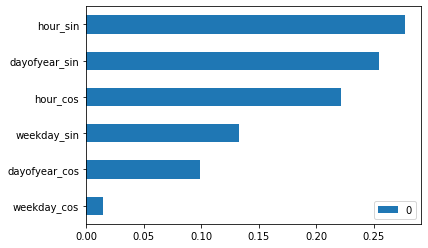

In [25]:
# Feature importance
pd.DataFrame(data=gs1.best_estimator_['est'].feature_importances_,
            index=features1_train.columns).sort_values(by=0).plot(kind='barh')

### Learning curves for best RF

In [25]:
model1 = RandomForestRegressor(max_depth=8,
                               max_features=1.0,
                               min_samples_split=0.005,
                               n_estimators=75,
                               min_samples_leaf=2,
                               random_state=100,
                               n_jobs=-1) 

In [26]:
model1 = gs1.best_estimator_['est']

In [27]:
train_size, train_scores, cv_scores = learning_curve(model1, 
                                                     X=features1_train, 
                                                     y=target1_train, 
                                                     cv=5,
                                                     scoring='neg_mean_squared_error',
                                                     random_state=100)

Plot learning curves

Text(0, 0.5, 'MSE')

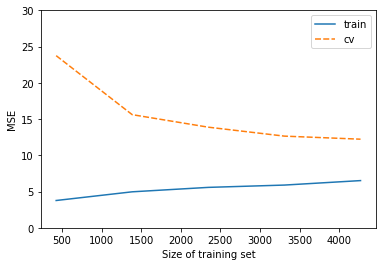

In [28]:
g = sns.lineplot(data= pd.DataFrame({'train': -train_scores.mean(axis=1), 'cv': -cv_scores.mean(axis=1)}, 
                                index=train_size))
g.axes.set_ylim(0,30)
g.set_xlabel('Size of training set')
g.set_ylabel('MSE')

## New model using `is_holiday` 

Now we will include data from 2017 only, along with variables depending on time, including the `is_holiday` variable.

In [26]:
# Filter rows used in previous model
features2 = union_df[(union_df.year == 2017) & (union_df.created == 0)]
target2 = features2.rate_of_change

In [27]:
features2.shape

(6673, 18)

In [28]:
# Variables to include
include2 = ['dayofyear_sin', 'dayofyear_cos', 'weekday_sin', 'weekday_cos', 'hour_sin', 'hour_cos', 'is_holiday']

# Subset the dataframe
features2 = features2[features2.columns[features2.columns.isin(include2)]]

Split the dataset into training and test set for Cross validation and hyper parameters optimization

In [29]:
features2_train, features2_test, target2_train, target2_test = train_test_split(features2,
                                                                                target2, 
                                                                                test_size=0.2, 
                                                                                random_state=100)

In [30]:
features2_train.shape[0], features2_test.shape[0]

(5338, 1335)

In [31]:
#Create params grid
pipe = Pipeline([('est', RandomForestRegressor(random_state=100))])

params_list = [{'est__n_estimators': np.linspace(50, 100, 3, endpoint=True, dtype=int),
                'est__max_depth' : np.linspace(5, 10, 3, endpoint=True, dtype=int),
                'est__min_samples_split': np.linspace(0.0001, 0.001, 5, endpoint=True),
                'est__min_samples_leaf': np.linspace(1, 10, 4, endpoint=True, dtype=int),
                'est__max_features': [0.75, 1]}]

# Perform grid search
gs2 = GridSearchCV(estimator= pipe,
                           param_grid=params_list, 
                           cv=5, 
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)

gs2.fit(features2_train, target2_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('est',
                                        RandomForestRegressor(bootstrap=True,
                                                              ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                              max_samples=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=None,
                                                              min_samples_leaf=1,
                                                        

In [32]:
#Get best score
gs2.best_score_.round(2)

-11.68

Now we will evaluate $R^{2}$ as the metric for model selection in training and test

In [33]:
#Use the best model for prediction on training set and get metric
r2_score(target2_train, gs2.predict(features2_train)).round(2)

0.82

In [34]:
#Use the best model for prediction on training set and get metric
mean_squared_error(target2_train, gs2.predict(features2_train)).round(2)

6.86

In [35]:
#Use the best model for prediction on test set and get metric
r2_score(target2_test, gs2.predict(features2_test)).round(2)

0.71

In [36]:
#Use the best model for prediction on test set and get metric
mean_squared_error(target2_test, gs2.predict(features2_test)).round(2)

12.51

In [37]:
# Feature importance
pd.DataFrame(data=gs2.best_estimator_['est'].feature_importances_,
            index=features2_train.columns)

,0
is_holiday,0.018291
dayofyear_sin,0.248261
dayofyear_cos,0.091046
weekday_sin,0.135193
weekday_cos,0.012777
hour_sin,0.275694
hour_cos,0.218737


### Learning curves for best RF

In [38]:
model2 = RandomForestRegressor(max_depth=9,
                               max_features=1.0,
                               min_samples_split=0.008,
                               n_estimators=75,
                               min_samples_leaf=3,
                               random_state=100,
                               n_jobs=-1) 

In [39]:
model2 = gs2.best_estimator_['est']

In [40]:
train_size, train_scores, cv_scores = learning_curve(model2, 
                                                     X=features2_train, 
                                                     y=target2_train, 
                                                     cv=5,
                                                     scoring='neg_mean_squared_error',
                                                     random_state=100)

Plot learning curves

Text(0, 0.5, 'MSE')

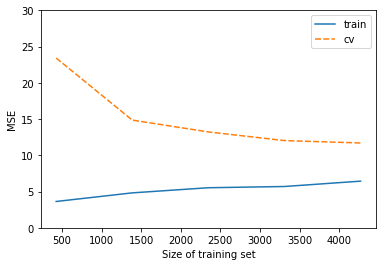

In [41]:
g = sns.lineplot(data= pd.DataFrame({'train': -train_scores.mean(axis=1), 'cv': -cv_scores.mean(axis=1)}, 
                                index=train_size))
g.axes.set_ylim(0,30)
g.set_xlabel('Size of training set')
g.set_ylabel('MSE')

The model performance improved in general, and some bias was reduced from the model. However, it wasn't enough for having a significant impact on the model metrics. Next we will bring some more training examples to try to reduce variance, as indicated by the learning curves.

## New model using `is_holiday` and zero-counts rows

Now we will include data from 2017 only, along with variables depending on time, including the `is_holiday` variable.

In [42]:
# Filter rows used in previous model
features3 = union_df[(union_df.year == 2017)]
target3 = features3.rate_of_change

In [43]:
features3.shape

(8760, 18)

In [44]:
features3.columns

Index(['year', 'month', 'dayofyear', 'weekday', 'hour', 'rate_of_change',
       'wind_chill', 'rel_hum_', 'rain', 'snow', 'created', 'is_holiday',
       'dayofyear_sin', 'dayofyear_cos', 'weekday_sin', 'weekday_cos',
       'hour_sin', 'hour_cos'],
      dtype='object')

In [45]:
# Variables to include
include3 = ['dayofyear_sin', 'dayofyear_cos', 'weekday_sin', 'weekday_cos', 'hour_sin', 'hour_cos', 'is_holiday']

# Subset the dataframe
features3 = features3[features3.columns[features3.columns.isin(include3)]]

Split the dataset into training and test set for Cross validation and hyper parameters optimization

In [46]:
features3_train, features3_test, target3_train, target3_test = train_test_split(features3,
                                                                                target3, 
                                                                                test_size=0.2, 
                                                                                random_state=100)

In [47]:
features3_train.shape[0], features3_test.shape[0]

(7008, 1752)

In [48]:
#Create params grid
pipe = Pipeline([('est', RandomForestRegressor(random_state=100))])

params_list = [{'est__n_estimators': np.linspace(50, 100, 3, endpoint=True, dtype=int),
                'est__max_depth' : np.linspace(5, 10, 3, endpoint=True, dtype=int),
                'est__min_samples_split': np.linspace(0.0001, 0.001, 5, endpoint=True),
                'est__min_samples_leaf': np.linspace(1, 10, 4, endpoint=True, dtype=int),
                'est__max_features': [0.75, 1]}]

# Perform grid search
gs3 = GridSearchCV(estimator= pipe,
                           param_grid=params_list, 
                           cv=5, 
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)

gs3.fit(features3_train, target3_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('est',
                                        RandomForestRegressor(bootstrap=True,
                                                              ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                              max_samples=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=None,
                                                              min_samples_leaf=1,
                                                        

In [49]:
#Get best score
gs3.best_score_.round(2)

-9.77

Now we will evaluate $R^{2}$ as the metric for model selection in training and test

In [50]:
#Use the best model for prediction on training set and get metric
r2_score(target3_train, gs3.predict(features3_train)).round(2)

0.82

In [51]:
#Use the best model for prediction on training set and get metric
mean_squared_error(target3_train, gs3.predict(features3_train)).round(2)

5.46

In [52]:
#Use the best model for prediction on test set and get metric
r2_score(target3_test, gs3.predict(features3_test)).round(2)

0.71

In [53]:
#Use the best model for prediction on test set and get metric
mean_squared_error(target3_test, gs3.predict(features3_test)).round(2)

8.3

In [54]:
# Feature importance
pd.DataFrame(data=gs3.best_estimator_['est'].feature_importances_,
            index=features3_train.columns)

,0
is_holiday,0.017019
dayofyear_sin,0.258752
dayofyear_cos,0.102145
weekday_sin,0.126041
weekday_cos,0.012518
hour_sin,0.248388
hour_cos,0.235137


### Learning curves for best RF

In [60]:
model3 = gs3.best_estimator_['est']
model3

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features=0.75, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=0.00055, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=100, verbose=0, warm_start=False)

In [61]:
train_size, train_scores, cv_scores = learning_curve(model3, 
                                                     X=features3_train, 
                                                     y=target3_train, 
                                                     cv=5,
                                                     scoring='neg_mean_squared_error',
                                                     random_state=100)

Plot learning curves

Text(0, 0.5, 'MSE')

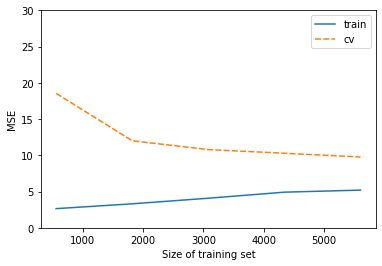

In [62]:
g = sns.lineplot(data= pd.DataFrame({'train': -train_scores.mean(axis=1), 'cv': -cv_scores.mean(axis=1)}, 
                                index=train_size))
g.axes.set_ylim(0,30)
g.set_xlabel('Size of training set')
g.set_ylabel('MSE')

This is by far the best model we have so far. There was significant improvement on the test set (reduced variance) while also improving overall metrics. This proves that we could further increase model performance by gathering more examples and that indeed our problem is variance.

## New model using `is_holiday`, weather-variables and zero-counts rows

Now we will include data from 2016 and 2017, along with variables depending on time, including the `is_holiday` variable, and all the weather variables available.

In [55]:
# Filter rows used in previous model
features5 = union_df[(union_df.year == 2017)]
target5 = features5.rate_of_change

In [134]:
features5.shape

(8760, 18)

In [135]:
features5.columns

Index(['year', 'month', 'dayofyear', 'weekday', 'hour', 'rate_of_change',
       'wind_chill', 'rel_hum_', 'rain', 'snow', 'created', 'is_holiday',
       'dayofyear_sin', 'dayofyear_cos', 'weekday_sin', 'weekday_cos',
       'hour_sin', 'hour_cos'],
      dtype='object')

In [136]:
# Variables to include
include5 = ['dayofyear_sin', 'dayofyear_cos', 'weekday_sin', 'weekday_cos', 'hour_sin', 'hour_cos', 
            'is_holiday', 'wind_chill']

# Subset the dataframe
features5 = features5[features5.columns[features5.columns.isin(include5)]]

Split the dataset into training and test set for Cross validation and hyper parameters optimization

In [137]:
features5_train, features5_test, target5_train, target5_test = train_test_split(features5,
                                                                                target5, 
                                                                                test_size=0.2, 
                                                                                random_state=100)

In [138]:
features5_train.shape[0], features5_test.shape[0]

(7008, 1752)

In [61]:
#Create params grid
pipe = Pipeline([('est', RandomForestRegressor(random_state=100))])

params_list = [{'est__n_estimators': np.linspace(50, 150, 4, endpoint=True, dtype=int),
                'est__max_depth' : np.linspace(5, 10, 3, endpoint=True, dtype=int),
                'est__min_samples_split': np.linspace(0.0001, 0.001, 5, endpoint=True),
                'est__min_samples_leaf': np.linspace(1, 10, 4, endpoint=True, dtype=int),
                'est__max_features': [0.75, 1]}]

# Perform grid search
gs5 = GridSearchCV(estimator= pipe,
                           param_grid=params_list, 
                           cv=5, 
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)

gs5.fit(features5_train, target5_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('est',
                                        RandomForestRegressor(bootstrap=True,
                                                              ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                              max_samples=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=None,
                                                              min_samples_leaf=1,
                                                        

In [62]:
#Get best score
gs5.best_score_.round(2)

-10.08

Now we will evaluate $R^{2}$ as the metric for model selection in training and test

In [63]:
#Use the best model for prediction on training set and get metric
r2_score(target5_train, gs5.predict(features5_train)).round(2)

0.82

In [64]:
#Use the best model for prediction on training set and get metric
mean_squared_error(target5_train, gs5.predict(features5_train)).round(2)

5.45

In [65]:
#Use the best model for prediction on test set and get metric
r2_score(target5_test, gs5.predict(features5_test)).round(2)

0.72

In [66]:
#Use the best model for prediction on test set and get metric
mean_squared_error(target5_test, gs5.predict(features5_test)).round(2)

8.23

In [67]:
# Feature importance
pd.DataFrame(data=gs5.best_estimator_['est'].feature_importances_,
            index=features5_train.columns)

,0
wind_chill,0.088862
is_holiday,0.015266
dayofyear_sin,0.227140
dayofyear_cos,0.064733
weekday_sin,0.130642
weekday_cos,0.010983
hour_sin,0.247027
hour_cos,0.215346


### Learning curves for best RF

In [68]:
model5 = gs5.best_estimator_['est']
model5

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features=0.75, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=0.00055, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=None, oob_score=False,
                      random_state=100, verbose=0, warm_start=False)

In [69]:
train_size, train_scores, cv_scores = learning_curve(model5, 
                                                     X=features5_train, 
                                                     y=target5_train, 
                                                     cv=5,
                                                     scoring='neg_mean_squared_error',
                                                     random_state=100)

Plot learning curves

Text(0, 0.5, 'MSE')

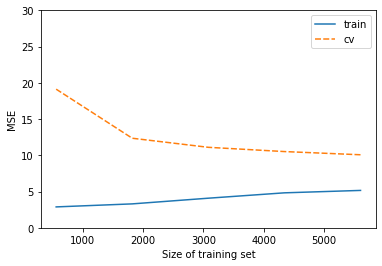

In [70]:
g = sns.lineplot(data= pd.DataFrame({'train': -train_scores.mean(axis=1), 'cv': -cv_scores.mean(axis=1)}, 
                                index=train_size))
g.axes.set_ylim(0,30)
g.set_xlabel('Size of training set')
g.set_ylabel('MSE')

### SHAP analysis 

In [73]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [74]:
import shap

In [75]:
shap.initjs()

In [80]:
# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(model5)
shap_values_train = explainer.shap_values(features5_train)
shap_values_test = explainer.shap_values(features5_test)

In [ ]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], features5_train.iloc[0,:],
               matplotlib=True)

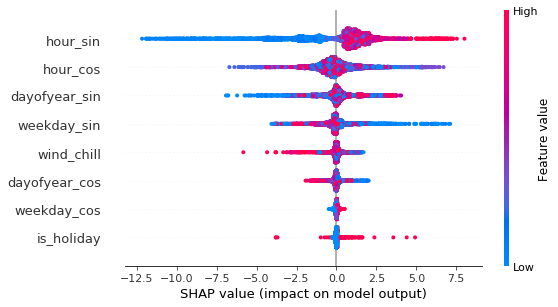

In [84]:
# summarize the effects of all the features
shap.summary_plot(shap_values_train, features5_train)

In [87]:
features5_test.columns

Index(['wind_chill', 'is_holiday', 'dayofyear_sin', 'dayofyear_cos',
       'weekday_sin', 'weekday_cos', 'hour_sin', 'hour_cos'],
      dtype='object')

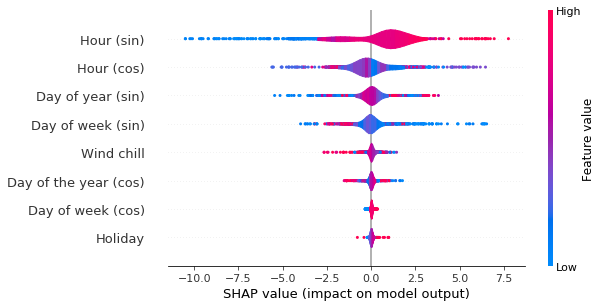

In [88]:
# summarize the effects of all the features
shap.summary_plot(shap_values_test, features5_test, plot_type='violin',
                 feature_names=['Wind chill', 'Holiday', 'Day of year (sin)', 'Day of the year (cos)', 
                                'Day of week (sin)', 'Day of week (cos)', 'Hour (sin)', 'Hour (cos)' ])


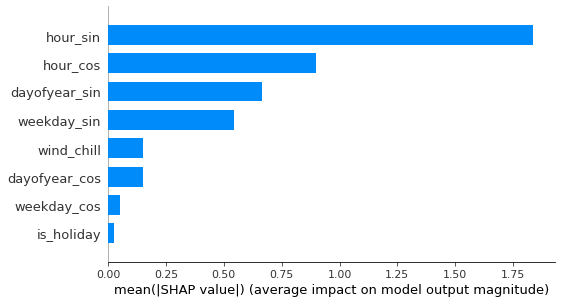

In [89]:
shap.summary_plot(shap_values_test, features5_test, plot_type="bar")

### Evaluating predictions for months of high demand

We will compare the predictions for June, July and August into a timeline with the real data to review overall model performance.

In [139]:
difference = target5 - gs5.predict(features5)

In [140]:
# Filter rows used in previous model
features5 = union_df[(union_df.year == 2017)]
target5 = features5.rate_of_change

<function matplotlib.pyplot.show(*args, **kw)>

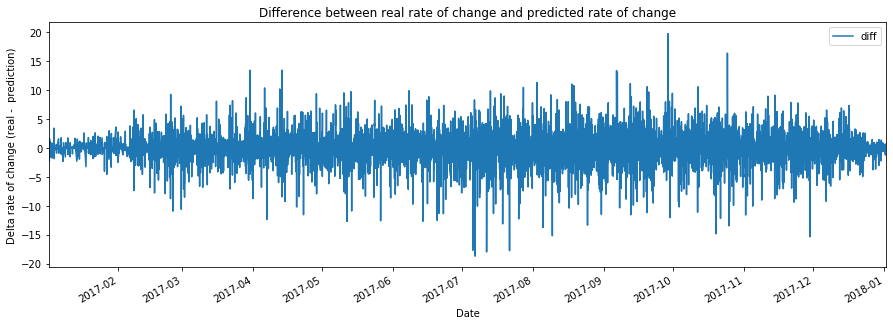

In [155]:
#Plot
fig, axes= plt.subplots(nrows=1, ncols=1,figsize=(15,5))
pd.DataFrame(data={'diff': difference, 'date': [datetime.strptime(''.join([str(int(row[1]['year'])), str(int(row[1]['dayofyear'] + 1)), str(int(row[1]['hour']))]), '%Y%j%H') for row in features5.iterrows()]}).set_index('date').plot(ax=axes)
plt.xlabel('Date')
plt.ylabel('Delta rate of change (real -  prediction)')
plt.title('Difference between real rate of change and predicted rate of change')
plt.show


## Modeling as a classification model 

In [115]:
# Filter rows used in previous model
features6 = union_df.copy()
target6 = features6.rate_of_change

In [116]:
features6.shape

(13176, 18)

In [117]:
def to_categorical(val):
    if val > 8.5*2:
        return 2
    if val < -8.5*2:
        return 2
    if (val > 8.5) & (val < 8.5*2):
        return 1
    if (val < -8.5) & (val > -8.5*2):
        return 1
    else:
        return 0

In [118]:
target6 = target6.apply(lambda x: to_categorical(x))

In [119]:
target6.value_counts(normalize=True)

0    0.921448
1    0.055024
2    0.023528
Name: rate_of_change, dtype: float64

In [121]:
# Variables to include
include6 = ['weekday_sin', 'weekday_cos', 'hour_sin', 'hour_cos', 'is_holiday', 'wind_chill', 'rel_hum_','rain', 'snow']

# Subset the dataframe
features6 = features6[features6.columns[features6.columns.isin(include6)]]

Split the dataset into training and test set for Cross validation and hyper parameters optimization

In [122]:
features6_train, features6_test, target6_train, target6_test = train_test_split(features6,
                                                                                target6, 
                                                                                test_size=0.2, 
                                                                                random_state=100)

In [123]:
features6_train.shape[0], features6_test.shape[0]

(2635, 659)

In [124]:
target6_train.value_counts()

 0    1127
-1     879
 1     629
Name: rate_of_change, dtype: int64

Perform sampling for imbalanced dataset

In [90]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler

In [91]:
sampler = SMOTE()

In [92]:
features6_train_sm, target6_train_sm = sampler.fit_sample(features6_train, target6_train)

Conver to dataframe

In [93]:
target6_train_sm = pd.Series(target6_train_sm)

In [94]:
features6_train_sm = pd.DataFrame(features6_train_sm, columns=features6_train.columns)

In [95]:
features6_train_sm.shape[0], target6_train_sm.shape[0]

(4824, 4824)

In [96]:
target6_train_sm.value_counts()

-1    1608
 1    1608
 0    1608
dtype: int64

Fit the model

In [125]:
clf1 = XGBClassifier(class_weight='balanced', random_state=100)
clf1.fit(features6_train, target6_train)

XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [126]:
print(classification_report(target6_train, clf1.predict(features6_train)))

              precision    recall  f1-score   support

          -1       0.58      0.47      0.52       879
           0       0.57      0.80      0.67      1127
           1       0.49      0.26      0.34       629

    accuracy                           0.56      2635
   macro avg       0.55      0.51      0.51      2635
weighted avg       0.55      0.56      0.54      2635



In [127]:
print(classification_report(target6_test, clf1.predict(features6_test)))

              precision    recall  f1-score   support

          -1       0.49      0.38      0.42       225
           0       0.53      0.75      0.62       274
           1       0.37      0.21      0.27       160

    accuracy                           0.49       659
   macro avg       0.46      0.45      0.44       659
weighted avg       0.47      0.49      0.47       659



In [46]:
# Feature importance
pd.DataFrame(data=clf1.feature_importances_,
            index=features6_train.columns)

,0
wind_chill,0.096100
rel_hum_,0.036717
rain,0.043610
snow,0.040248
is_holiday,0.059209
weekday_sin,0.155447
weekday_cos,0.046402
hour_sin,0.370829
hour_cos,0.151438


### Final remarks

* The most important factor for prediction is the hour of the day, both on the cosine and sine components. The dayofyear and weekday also have some influence, mainly on their sine component, since these are the variables that provide information about weekly and yearly seasonality.

* In terms of prediction for months of high demand, the model seems to do a good job on most days, in which the difference between the real value and prediction are close to zero and between the $[-5,5]$ range, with a capacity of 26 bikes, this error might be acceptable (depending on the hour of the day). However, several peak points in the difference are still present, it's important identify explanatory variables for those peaks in order to improve model performance.

* This model could be used for predicting the performance of other stations aswell since the data is already clean and prepared for the analysis.
